In [113]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [121]:
races = pd.read_csv('all_races.csv', nrows = 10000)
races.head()

,place,age_class,place_in_class,bib,name,sex,nation,team,official_time,net_time,birth_date,event,event_year,distance
0,1,M20,1,1,Rui Pedro Silva,M,PT,Individual,0 days 00:29:56.000000000,0 days 00:29:53.000000000,01/01/1992,dia-do-pai,2012,10
1,2,M20,2,184,Paulo Gomes,M,PT,Individual,0 days 00:29:58.000000000,0 days 00:29:58.000000000,01/01/1992,dia-do-pai,2012,10
2,3,M20,3,3,Bruno Albuquerque,M,PT,Sporting C P,0 days 00:30:20.000000000,0 days 00:30:18.000000000,01/01/1992,dia-do-pai,2012,10
3,4,M20,4,84,Manuel Sousa,M,PT,C I Argoncilhe,0 days 00:31:27.000000000,0 days 00:31:25.000000000,01/04/1972,dia-do-pai,2012,10
4,5,M20,5,4,Luis Mendes,M,PT,Cyclones Sanitop,0 days 00:31:46.000000000,0 days 00:31:45.000000000,01/01/1992,dia-do-pai,2012,10


In [122]:
def clean_data(df):
    # fix one missing net time
    flt = (df.place==1)&(df.event=='family-race')&(df.event_year==2015)
    df.loc[flt, 'net_time'] = df[flt].official_time
    df.official_time = pd.to_timedelta(df.official_time)
    # many cases of missing net time
    df.net_time = np.where(df.net_time=='-', np.nan, df.net_time)
    df.net_time = pd.to_timedelta(df.net_time)
    # extract the date
    df['birth_year'] = df['birth_date'].str[6:].astype(int)
    return df
    
def input_missing_event_net_time(df):
    # if the runner is on top10, set missing net time equal to the official time
    df.net_time = np.where((df.net_time.isnull())&(df.place <= 10), 
                            df.official_time, df.net_time)
    df['delay_time'] = df['official_time'].dt.seconds - df['net_time'].dt.seconds
    df['delay_time_mean'] = df.delay_time.rolling(window=10, min_periods=5).mean()
    df['net_time_mean_sec'] = df['official_time'].dt.seconds - df['delay_time_mean']
    df['net_time'] = np.where(df.net_time.isnull(),
                            pd.to_timedelta(df.net_time_mean_sec, unit='s'), 
                            df.net_time)
    df = df.drop(['net_time_mean_sec','delay_time_mean','delay_time'], axis=1)
    assert not (df.official_time < df.net_time).any() 
    assert not df.net_time.isnull().any() 
    return df

def add_features(df):
    df['pace'] = df.net_time / df.distance
    return df

In [123]:
races = clean_data(races)
races = races.groupby(['event','event_year']).apply(input_missing_event_net_time)
races = add_features(races)

In [124]:
# using combination of name and birth date to identify unique runners
races['birth_date_name'] = races['birth_date'] + '_' + races['name']

In [125]:
# which years have both marathon and half marathon data
years = set(races[races.event=='maratona'].event_year.unique()) & \
set(races[races.event=='meia_maratona'].event_year.unique())
years

set()

In [126]:
races_train = pd.DataFrame()
for year in years:
    marathon_runners = races[(races.event_year==year)&(races.event=='maratona')].birth_date_name
    half_events = races[(races.event_year==year)&(races.event=='meia_maratona')&(
                        races.birth_date_name.isin(marathon_runners))]
    half_and_marathon_runners = half_events.birth_date_name.values
    concat_df = races[(races.event_year==year)&(
                                    races.event.isin(['maratona', 'meia_maratona']))&(
                                    races.birth_date_name.isin(half_and_marathon_runners))]
    races_train = pd.concat([races_train, concat_df])
   

In [127]:
races_train = pd.DataFrame()
for year in years:
    marathon_runners = races[(races.event_year==year)&(races.event=='maratona')].birth_date_name
    half_events = races[(races.event_year==year)&(races.event=='meia_maratona')&(
                        races.birth_date_name.isin(marathon_runners))]
    half_and_marathon_runners = half_events.birth_date_name.values
    races_train = races_train.append(races[(races.event_year==year)&(
                                    races.event.isin(['maratona','meia_maratona']))&(
                                    races.birth_date_name.isin(half_and_marathon_runners))])

In [130]:
races_train['age_class'] = races_train.age_class.fillna('NA')
# encode categorical variable
le = LabelEncoder()
le.fit(races_train.age_class.values)
races_train['age_class'] = le.transform(races_train.age_class.values)
# races_train = pd.merge(marathon, half, on=['event_year','birth_date_name'], how='left')
# races_train.head(2)

AttributeError: 'DataFrame' object has no attribute 'age_class'

In [131]:
x_train, x_test, y_train, y_test = train_test_split(races_train[['age_class','half_net_time']].values,
                         races_train.marathon_net_time.values, test_size=0.25, random_state=42)

KeyError: "None of [Index(['age_class', 'half_net_time'], dtype='object')] are in the [columns]"

In [ ]:
lr = LinearRegression()
lr.fit(x_train[:,1].reshape(-1,1),y_train) 
ypred = lr.predict(x_test[:,1].reshape(-1,1))
metrics.mean_absolute_error(y_test, ypred)

In [ ]:
x = [t for t in range(80,140)]
yval = [lr.predict([[t]])[0] for t in x]
plt.scatter(races_train.half_net_time.values, races_train.marathon_net_time.values, alpha=0.1)
plt.plot(x, yval, color='red')
plt.xlabel('Half marathon net time (min)')
plt.ylabel('Marathon net time (min)')
plt.title('Model predictions');

In [ ]:
quad_x_train = np.array([x_train[:,1], x_train[:,1]**2]).T
lr.fit(quad_x_train, y_train) 
quad_x_test = np.array([x_test[:,1], x_test[:,1]**2]).T
ypred = lr.predict(quad_x_test)
metrics.mean_absolute_error(y_test, ypred)

In [ ]:
x = [t for t in range(80,140)]
yval = [lr.predict([[t, t**2]])[0] for t in x]
plt.scatter(races_train.half_net_time.values, races_train.marathon_net_time.values, alpha=0.1)
plt.plot(x, yval, color='red')
plt.xlabel('Half marathon net time (min)')
plt.ylabel('Marathon net time (min)')
plt.title('Model predictions (quadratic model)');


In [48]:
pred = lr.predict([[128, 128**2]])[0]
'{:1.0f}h {:2.0f}m'.format(*divmod(pred, 60))

'1h 42m'

In [49]:
pred = lr.predict([[108, 108**2]])[0]
'{:1.0f}h {:2.0f}m'.format(*divmod(pred, 60))

'1h 32m'

Gradiant Boosting Machine


In [50]:
model = xgb.XGBRegressor(max_depth=3, learning_rate=0.02, n_estimators=300,
                        random_state=42)


In [51]:
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='mae', 
            early_stopping_rounds=15, verbose=False)
ypred = model.predict(x_test)
metrics.mean_absolute_error(y_test, ypred)

C:\Users\Pransu\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Pransu\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.3665061385543256

In [52]:
print(list(enumerate(le.classes_)))

[(0, 17), (1, 20), (2, 40), (3, 45), (4, 50), (5, 55)]


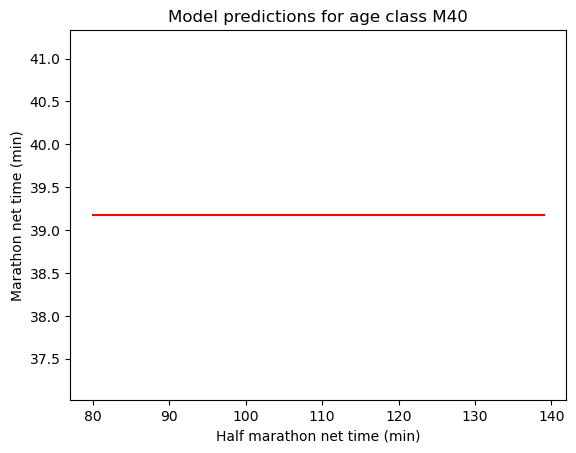